# Milestone 1: Group 17
Authors: Rus Dimitrov, Elena Ganacheva, Luke Yang, Shirley Zhang

In [1]:
import re
import os
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd

In [2]:
# Set up data source directory *Needs to be set up differently for each group member*
%cd /Users/luke/Desktop/MDS/DSCI 525/DSCI-525-Group-17

/Users/luke/Desktop/MDS/DSCI 525/DSCI-525-Group-17


## 1. & 2. Team Work Contract & Project Repository

Please see our Milestone 1 submission on Canvas. 

## 3. Downloading the data

In [3]:
# Necessary metadata
article_id = 14096681  
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "data/"

In [4]:
response = requests.request("GET", url, headers=headers)
data = json.loads(response.text) 
files = data["files"]            
files

[{'id': 26579150,
  'name': 'daily_rainfall_2014.png',
  'size': 58863,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579150',
  'supplied_md5': 'fd32a2ffde300a31f8d63b1825d47e5e',
  'computed_md5': 'fd32a2ffde300a31f8d63b1825d47e5e'},
 {'id': 26579171,
  'name': 'environment.yml',
  'size': 192,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579171',
  'supplied_md5': '060b2020017eed93a1ee7dd8c65b2f34',
  'computed_md5': '060b2020017eed93a1ee7dd8c65b2f34'},
 {'id': 26586554,
  'name': 'README.md',
  'size': 5422,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26586554',
  'supplied_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c',
  'computed_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c'},
 {'id': 26766812,
  'name': 'data.zip',
  'size': 814041183,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26766812',
  'supplied_md5': 'b517383f76e77bd03755a63a8f

In [5]:
%%time
files_to_dl = ["data.zip"]
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(output_directory, exist_ok=True)
        urlretrieve(file["download_url"], output_directory + file["name"])

CPU times: user 2.16 s, sys: 2.7 s, total: 4.86 s
Wall time: 2min 26s


In [6]:
%%time
with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), 'r') as f:
    f.extractall(output_directory)

CPU times: user 7.25 s, sys: 1.03 s, total: 8.28 s
Wall time: 8.48 s


## 4. Combining data CSVs

In [7]:
%%time
# Combine csv files into one pandas data frame
files = glob.glob('data/*.csv')
df = pd.concat((pd.read_csv(file, index_col=0)
                .assign(model=file.split('/')[1].split('_')[0]) # needs to be changed from / to \\ for Windows
                for file in files)
              )
df.to_csv("data/combined_data.csv")

CPU times: user 3min 2s, sys: 9.86 s, total: 3min 12s
Wall time: 3min 13s


> Please see chart below for all times for all team members for both Q4 and Q5 as well as comments on our observations

## 5. Load the combined CSV to memory and perform a simple EDA

In [8]:
%%time
# Trying to load in chunks and filter for values after 2000 and greater than 1
counts = pd.Series(dtype=int)
for chunk in pd.read_csv("data/combined_data.csv", chunksize=10_000_000):
    chunk['time'] = pd.to_datetime(chunk['time'])
    counts = counts.add(chunk[(chunk['time'] >=pd.to_datetime(2000)) & (chunk['rain (mm/day)'] >1)]["rain (mm/day)"].value_counts(), fill_value=0)
print(counts.astype(int))

1.000001      1
1.000003      1
1.000003      1
1.000003      1
1.000003      1
             ..
276.016970    1
279.512002    1
316.547388    1
321.963371    1
432.939515    1
Length: 4896937, dtype: int64
CPU times: user 35.9 s, sys: 5.72 s, total: 41.6 s
Wall time: 42.8 s


**In the code below, we tried the following two approaches to reduce memory usage while performing EDA:**
1. Loading just the columns we want 
2. Loading in chunks

In [9]:
%%time
# EDA (decided to focus only on the rain column and values greater than 10 as "rainy days")
count_rainy_days = pd.Series(dtype=int)
for chunk in pd.read_csv("data/combined_data.csv", chunksize=10_000_000, usecols=["rain (mm/day)"]):
    count_rainy_days = count_rainy_days.add(chunk[(chunk > 10)], fill_value=0)

count_rainy_days = count_rainy_days.dropna()
print((count_rainy_days))

          rain (mm/day)
10000012      24.457625
10000013      20.367342
10000014      33.328206
10000031      16.203621
10000039      10.811434
...                 ...
62513838      52.754753
62513847      17.760353
62513849      17.165935
62513860      10.005026
62513862      68.117489

[2592005 rows x 1 columns]
CPU times: user 23 s, sys: 46.3 s, total: 1min 9s
Wall time: 1min 24s


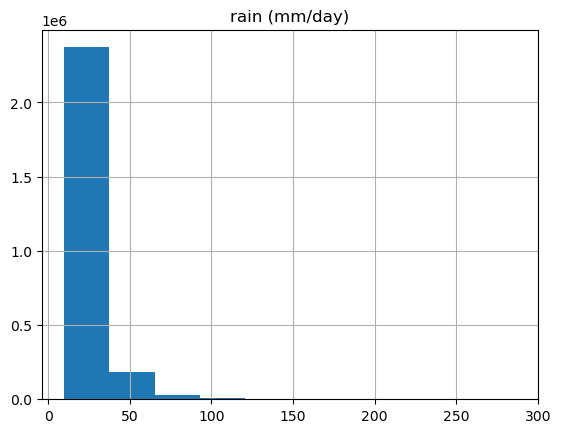

In [10]:
count_rainy_days.hist();

| Team Member | Operating System | RAM | Processor | Is SSD | Time taken Q4|Time taken Q5|
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|:----------:|
| Shirley    |   MacOS              |  8GB   |  Apple M2         |    TRUE    | 3min 15s           |    53.8s      |
| Luke    |MacOS|8GB|Apple M2|TRUE|3min 13s|1min 24s|
| Elena    |     Windows 10 Education             |  8GB   |   Intel Core i5-10210U       |  TRUE      |  9min 39s          |  1min 32s        |
| Ruslan    |   Windows 10               |  8GB   |     AMD Ryzen 7      |      TRUE  |  10min 22s          |   2min 55s       |

### Observations

It seems that the processors and potentially the operating systems have an impact on the time taken to execute the downloading of the data and the EDA. We were not able to access the impact of RAM as we all have 8GB of RAM. More specifically, downloading the data took three times as long on the Windows devices than the Mac devices, but this is most likely due to the Apple M2 processor being more powerful than the processors of our Windows devices than the operating systems themselves. When it came to the EDA our differences were smaller, with the split between Windows and Mac devices disappearing as Elena's computer was able to complete it slightly faster than Luke's while Ruslan's was the slowest and Shirley's was the fastest. There must be other factors in play that we did not record that account for the differences in processing for the EDA. 

## 6. Perform a simple EDA in R

In [11]:
%load_ext rpy2.ipython

In [12]:
%%R
suppressMessages(library(dplyr))
suppressMessages(library(readr))
suppressMessages(library(ggplot2))

In [13]:
%%R -i count_rainy_days
head(count_rainy_days)


         rain (mm/day)
10000012      24.45762
10000013      20.36734
10000014      33.32821
10000031      16.20362
10000039      10.81143
10000043      18.19375


### Reasoning

We chose to use 'Pandas Exchange' (converting from pandas dataframe to R).
- This is because we wanted the notebook to run by itself from top to bottom. If we used a method like 'Parquet', we would be reading the .csv file twice (once for the Python EDA, and another time for the R EDA). This would take up a lot of memory, and the notebook would likely not be able to run fully.
- Furthermore, we decided to use 'Pandas Exchange' instead of 'Pyarrow' as the latter does not use pandas dataframes. Instead, it creates a unified format that is shared between Python and R. However, we still wanted to use pandas for our Python EDA (due to familiarity). Thus, we thought 'Pandas Exchange' would be more appropriate.
- Finally, we felt that 'Pandas Exchange' was relatively simple and easy to use, which facilitated the completion of this milestone. 

In [14]:
%%R
summary(count_rainy_days)

 rain (mm/day)   
 Min.   : 10.00  
 1st Qu.: 12.51  
 Median : 16.41  
 Mean   : 20.65  
 3rd Qu.: 23.98  
 Max.   :286.23  


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


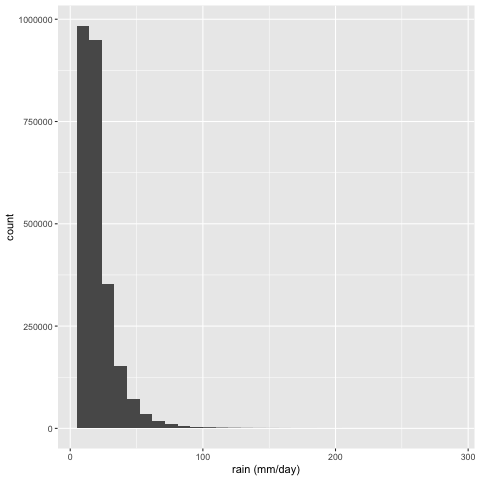

CPU times: user 1.19 s, sys: 87.2 ms, total: 1.27 s
Wall time: 3.8 s


In [15]:
%%time
%%R
ggplot(count_rainy_days) +
    geom_histogram(aes(x = `rain (mm/day)`))

## Challenges we faced

**Due to the size of the datafiles, a few of our team members had difficulties with running the notebook.**
- During lab time, one of our team member's laptop spent a lot of time combining the data. It took almost half an hour, before they stopped running the notebook altogether. 
    - To resolve this issue, they tried closing other windows that were open on their laptop and restarting the kernel. This seemed to help immensely and the code ran relatively quickly afterwards. 
- Another team member had some difficulty downloading the data. 
    - To resolve this issue, they retried the download when they got home with better wifi, and the data downloaded much quicker. 
    
**Another issue we ran into was accidentally printing or working with all of the dataset instead of filtering for just one column or just a few rows.**
- This was mainly because we were used to being able to print a small dataframe without having much issues, and were not as careful. However, when we printed a dataframe this time, the cell would take a long time to run and a lot of output would be printed, which we did not want. 
    - To resolve this issue, we started to become more careful and rechecked our code before we can each cell. 

**Finally, some of our team members had issues running `%%R` code cells.** 
- Specifically, the Windows laptops did not seem to be able to run R. 
    - To resolve this issue, we just allowed other team members who could run R code run those cells, since it is not necessary for R to be run for the rest of the course. 